In [1]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [2]:
f = r.TFile("./data/gm2lostMuonTree_full_run2timingoffsets.root")
f.cd("lostMuonTree")
f.ls()

t = f.Get("lostMuonTree/lostMuonCoincidences")
t.Print()

TFile**		./data/gm2lostMuonTree_full_run2timingoffsets.root	
 TFile*		./data/gm2lostMuonTree_full_run2timingoffsets.root	
  TDirectoryFile*		lostMuonTree	lostMuonTree (LostMuonTree) folder
   KEY: TTree	lostMuonCoincidences;24	lostMuonCoincidences
   KEY: TTree	lostMuonCoincidences;23	lostMuonCoincidences
  KEY: TDirectoryFile	lostMuonTree;1	lostMuonTree (LostMuonTree) folder
******************************************************************************
*Tree    :lostMuonCoincidences: lostMuonCoincidences                                   *
*Entries : 20913890 : Total =      2008078397 bytes  File  Size =  682262760 *
*        :          : Tree compression factor =   2.94                       *
******************************************************************************
*Br    0 :clusterEnergy : clusterEnergy/D                                    *
*Entries : 20913890 : Total  Size=  167340697 bytes  File Size  =  134907306 *
*Baskets :      252 : Basket Size=   25600000 bytes  Compr

Warning in <TDirectoryFile::Append>: Replacing existing TH1: energyXtal (Potential memory leak).


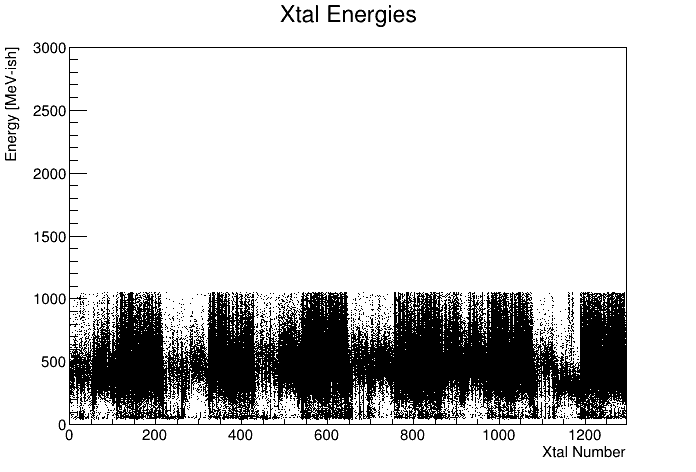

In [43]:
c = r.TCanvas()
allEnergies = r.TH2D("energyXtal","Xtal Energies; Xtal Number; Energy [MeV-ish]", 1296,-0.5,1295.5,400,0.0,3000.0)
t.Draw("xtalEnergy:(caloNum-1)*54 + xtalNum>>energyXtal","coinNum > 1 && nHit == 1","goff" )
allEnergies.Draw()
c.Draw()

In [44]:
targetE = 170.0 #MeV
scales = []
runningCalo = []

uncalibratedAllXtals = r.TH1D("uncalibratedAllXtals","All crystals",100,0.0,1000.0)
calibratedXtals = r.TH1D("calibratedXtals","All crystals; Energy [MeV]; N / 5 MeV",100,0.0,1000.0)

laserFactor = 0.2749;

#current bad xtals
ding = [ #(36, 100, 800)
       ]

#problemXtals = [3*54+6, 3*54 + 1, 5*54+47, 16*54 + 18, 16*54 + 27, 16*54 + 5, 16*54+4, 
#                16*54 + 45, 49, 45 + 54, 3*54 + 49, 8*54+18, 9*54+6, 11*54 + 2, 18*54 + 27, 
#                18*54 + 7, 21*54 + 4, 4*54 + 46, 47 + 54, 48+54, 5*54 + 47, 5*54 + 1]
#lower = [ 400, 375, 200, 450, 425, 350, 500, 350, 450, 150, 420, 350, 500, 450, 420, 420, 400, 200,350, 250, 200, 300]
#upper = [ 600, 575, 600, 450, 620, 600, 650, 550, 640, 850, 675, 600, 650, 750, 575, 600, 600, 400, 650, 550, 600, 600]

if(len(ding) > 0):
    problemXtals, lower, upper = zip(*ding)
else:
    problemXtals, lower, upper = ([],[],[])


if((len(problemXtals) != len(lower)) or (len(problemXtals) != len(upper)) or (len(upper) != len(lower))):
    print("WARNING! VECTORS HAVE DIFFERENT LENGTHS")


Warning in <TDirectoryFile::Append>: Replacing existing TH1: uncalibratedAllXtals (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: calibratedXtals (Potential memory leak).


In [45]:
laserConstants = [0.3 for x in range(24*54)]

In [46]:
len(laserConstants)

1296

In [47]:
projHist = allEnergies.ProjectionY("_py"+str(1),1,-1,"").Clone()
#projHist->Add(allEnergies.at(0)->ProjectionY(Form("_py%i",0),1,-1,""));
#projHist->Add(allEnergies.at(2)->ProjectionY(Form("_py%i",2),1,-1,""));
tempMean = projHist.GetMean()
tempSig = projHist.GetRMS()
binmax = projHist.GetMaximumBin()
peak = projHist.GetXaxis().GetBinCenter(binmax)
projHist.Fit("gaus","Q","",peak-75, peak+75)

avgPeak = peak;

scaleFactor = targetE / projHist.GetFunction("gaus").GetParameter(1)
print( "average calibration constant is : " , scaleFactor )

for k in range( 1,projHist.GetXaxis().GetNbins() ):
    uncalibratedAllXtals.Fill(projHist.GetXaxis().GetBinCenter(k) * scaleFactor,
                              projHist.GetBinContent(k))

average calibration constant is :  0.3766825487879743


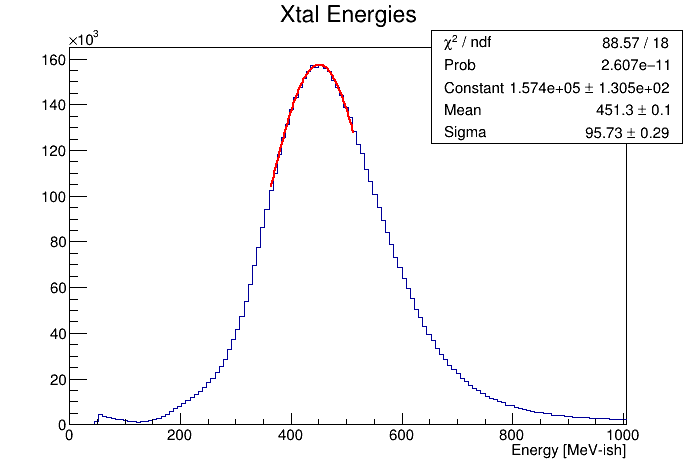

In [48]:
c = r.TCanvas()
projHist.Draw()
projHist.GetXaxis().SetRangeUser(0,1000)
c.Draw()

---

In [49]:
caloLow = 1
caloHigh = 24

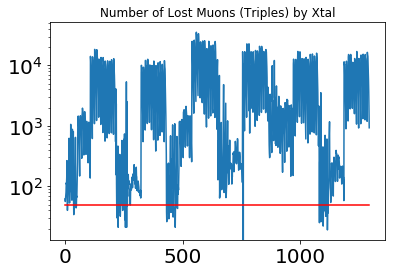

In [50]:
nMuons = []
xtalsBelowThreshold = []
for xIdx in range( (caloLow-1)*54+1 , caloHigh*54+1 ):
    #print("Starting crystal", xIdx)
    #projHist.Clear();
    #projHist=allEnergies.ProjectionY("_py"+str(xIdx*10+0),xIdx,xIdx,"").Clone()
    projHist = allEnergies.ProjectionY("_py",xIdx,xIdx,"").Clone("py")
    nMuons.append(projHist.GetEntries())
    if(projHist.GetEntries() <= 50):
        xtalsBelowThreshold.append(xIdx)
plt.plot(nMuons)
plt.yscale("log")
plt.plot([0,1296], [50,50], "r")
plt.title("Number of Lost Muons (Triples) by Xtal")
plt.show()

In [51]:
print(xtalsBelowThreshold)
print("Crystals below threshold of 50 mips:")
for x in xtalsBelowThreshold:
    print("   - calo", int(np.ceil(x/54)), "xtal", x%54)

[11, 38, 40, 48, 49, 221, 222, 224, 227, 230, 236, 237, 244, 246, 247, 255, 256, 258, 263, 266, 279, 433, 434, 442, 443, 444, 452, 461, 462, 470, 471, 472, 478, 479, 480, 759, 1084, 1091, 1093, 1100, 1101, 1102, 1109, 1111, 1118, 1119, 1120, 1121]
Crystals below threshold of 50 mips:
   - calo 1 xtal 11
   - calo 1 xtal 38
   - calo 1 xtal 40
   - calo 1 xtal 48
   - calo 1 xtal 49
   - calo 5 xtal 5
   - calo 5 xtal 6
   - calo 5 xtal 8
   - calo 5 xtal 11
   - calo 5 xtal 14
   - calo 5 xtal 20
   - calo 5 xtal 21
   - calo 5 xtal 28
   - calo 5 xtal 30
   - calo 5 xtal 31
   - calo 5 xtal 39
   - calo 5 xtal 40
   - calo 5 xtal 42
   - calo 5 xtal 47
   - calo 5 xtal 50
   - calo 6 xtal 9
   - calo 9 xtal 1
   - calo 9 xtal 2
   - calo 9 xtal 10
   - calo 9 xtal 11
   - calo 9 xtal 12
   - calo 9 xtal 20
   - calo 9 xtal 29
   - calo 9 xtal 30
   - calo 9 xtal 38
   - calo 9 xtal 39
   - calo 9 xtal 40
   - calo 9 xtal 46
   - calo 9 xtal 47
   - calo 9 xtal 48
   - calo 15 xtal 3
 

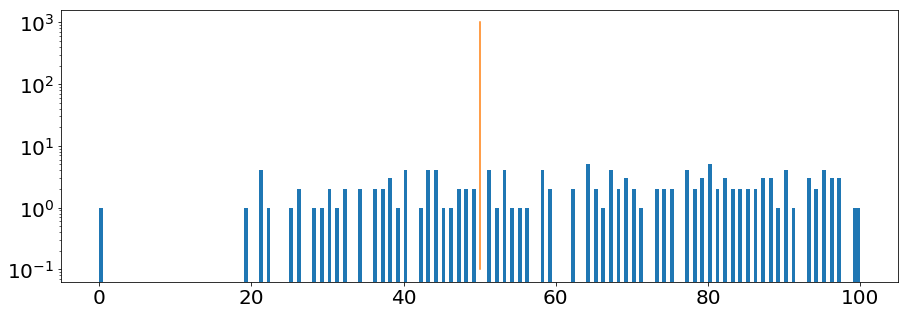

In [52]:
fig,ax = plt.subplots(figsize=(15,5))
plt.hist(nMuons,bins=200, range=(0,100))
plt.plot([50,50],[0.1,1000])
plt.yscale("log")
plt.show()

In [27]:
c2 = r.TCanvas("c2","c2",1800,1200);

#for(int xIdx = (caloLow-1)*54 + 1; xIdx <= caloHigh*54; xIdx++){//allEnergies.at(0)->GetXaxis()->GetNbins()
#for xIdx in range( (caloLow-1)*54 + 1, caloHigh*54 ):
for xIdx in range( (caloLow-1)*54+1 , caloHigh*54+1 ):
    print("Starting crystal", xIdx)
    #projHist.Clear();
    #projHist=allEnergies.ProjectionY("_py"+str(xIdx*10+0),xIdx,xIdx,"").Clone()
    projHist = allEnergies.ProjectionY("_py",xIdx,xIdx,"").Clone("py")
    projHist.SetTitle("Xtal "+str(xIdx))
    #for(int hit = 1; hit < allEnergies.size(); hit++){
    #    projHist->Add(allEnergies.at(hit)->ProjectionY(Form("_py%i",xIdx*10+hit),xIdx,xIdx,""));
    #}


    #projHist = allEnergies->ProjectionY(Form("_py%i",xIdx),xIdx,xIdx,"");
    #projHist->Rebin(4);

    if(projHist.GetEntries() > 50):
        
        tempMean = projHist.GetMean();
        tempSig = projHist.GetRMS();
        binmax = projHist.GetMaximumBin();
        peak = projHist.GetXaxis().GetBinCenter(binmax);
        peakValue = projHist.GetBinContent(binmax);
        
        while(peakValue < 50):
            #print("hi")
            projHist.Rebin(2);
            binmax = projHist.GetMaximumBin();
            peak = projHist.GetXaxis().GetBinCenter(binmax);
            peakValue = projHist.GetBinContent(binmax);
        #print("continuing")
                                                                
        mini = min([0.0,peak - 60]);
        maxi = max([3000.0,peak + 60]);

        #if(std::find(problemXtals.begin(),problemXtals.end(),xIdx-1)!=problemXtals.end()):
        problemXtal = False
        if( xIdx-1 in problemXtals ):
            problemXtal = True
            #pos = std::find(problemXtals.begin(),problemXtals.end(),xIdx-1) - problemXtals.begin();
            pos = problemXtals.index( xIdx - 1 )
            mini = lower[pos];
            maxi = upper[pos];
            print("     Problem xtal", xIdx)

        #print("fitting")
        for wnofiewrun in range(2):
            projHist.Fit("gaus","RQ","",mini, maxi);
        #if(not problemXtal):
        print("     ",mini, maxi)
        mini = max([0.0,projHist.GetFunction("gaus").GetParameter(1) - 1.5*projHist.GetFunction("gaus").GetParameter(2)]);
        maxi = min([3000.0,projHist.GetFunction("gaus").GetParameter(1) + 1.4*projHist.GetFunction("gaus").GetParameter(2)]);
        #delete projHist->GetFunction("gaus");
        print("     ",mini, maxi)
        projHist.Fit("gaus","RQ","",mini, maxi);
        #print("endfitting")
        runningCalo.append(projHist);
        scaleFactor = targetE / projHist.GetFunction("gaus").GetParameter(1);
        scales.append(scaleFactor);

        for k in range(1, projHist.GetXaxis().GetNbins() ):
            calibratedXtals.Fill(projHist.GetXaxis().GetBinCenter(k) * scaleFactor,
                                 projHist.GetBinContent(k));

    else:
        print( "Not enough events in channel : " , xIdx) 
        scales.append(1.0);
        runningCalo.append(projHist);

Starting crystal 1
      0.0 3000.0
      52.749125677307916 622.4707252173387
Starting crystal 2
      0.0 3000.0
      123.22325876737722 555.7239671783717
Starting crystal 3
      0.0 3000.0
      52.749125677030804 622.4707252173398
Starting crystal 4
      0.0 3000.0
      220.8544104946318 389.8786536374006
Starting crystal 5
      0.0 3000.0
      175.6314189971956 482.5160550477822
Starting crystal 6
      0.0 3000.0
      387.7484598184757 556.6899564743541
Starting crystal 7
      0.0 3000.0
      255.90342302270648 513.77631660433
Starting crystal 8
      0.0 3000.0
      311.80954388257516 399.52885616465164
Starting crystal 9
      0.0 3000.0
      251.50674919392483 481.56460504685754
Starting crystal 10
      0.0 3000.0
      479.80604321597673 480.52174329250334
Starting crystal 11
Not enough events in channel :  11
Starting crystal 12
      0.0 3000.0
      437.41035023155484 829.7009216690931
Starting crystal 13
      0.0 3000.0
      389.4377751119033 704.19579909087

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbin

In [ ]:
'''
TLine* line1;
if(xIdx%54 == 0){
    c2->Clear();
    c2->Divide(9,6);
    for(int drawdx = 0; drawdx < 54; drawdx++){
        c2->cd(54-drawdx);
        if(runningCalo.at(drawdx)->GetFunction("gaus")){
            runningCalo.at(drawdx)->GetFunction("gaus")->SetLineWidth(1);
        }
        double peakValue = runningCalo.at(drawdx)->GetBinContent(runningCalo.at(drawdx)->GetMaximumBin());
        //std::cout << "laser factor : " << laserConstants.at(xIdx-54+drawdx) << std::endl;
        double xValue = avgPeak * laserFactor / laserConstants.at(xIdx-54+drawdx) ;
        //std::cout << "xValue is : " << xValue << std::endl;
        line1 = new TLine( xValue, 0, xValue , 1.1*peakValue);
        line1->SetLineColorAlpha(kBlack,0.25);
        runningCalo.at(drawdx)->GetYaxis()->SetRangeUser(0,1.1*peakValue);
        runningCalo.at(drawdx)->GetXaxis()->SetRangeUser(0,2000.0);
        runningCalo.at(drawdx)->SetTitle(Form("xtal %i",drawdx));

        runningCalo.at(drawdx)->Draw();
        line1->Draw("same");
        c2->Update();
    }
    c2->Draw();
    c2->SaveAs(Form("caloPlotsTree/notFirstHit_1Xtal_calo%i.pdf",(int)(xIdx/54)));
    c2->Clear();
    runningCalo.clear();
}
'''

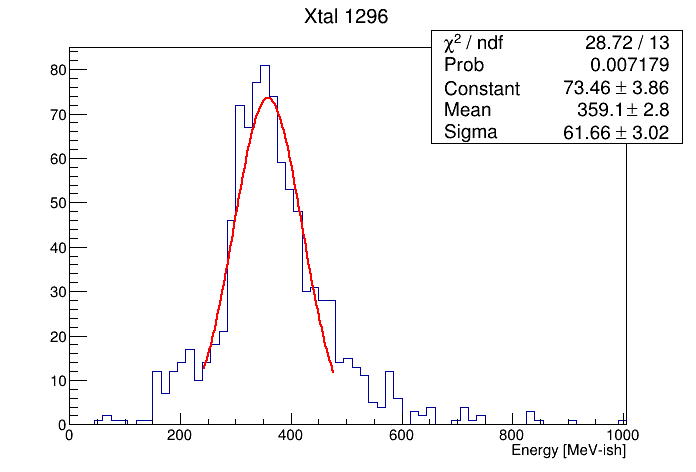

In [28]:
c = r.TCanvas()
#projHist.Fit("gaus")
projHist.GetXaxis().SetRangeUser(0,1000)
projHist.Draw()
c.Draw()

---


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


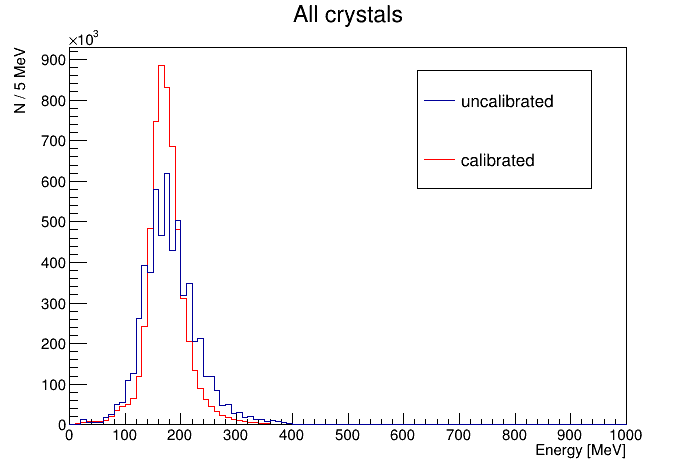

In [20]:
calibratedXtals.SetLineColor(2);
c1 = r.TCanvas("c1","c1",700,500);
leg1 = r.TLegend(0.6,0.6,0.85,0.85);
leg1.AddEntry(uncalibratedAllXtals,"uncalibrated","l");
leg1.AddEntry(calibratedXtals,"calibrated","l");
calibratedXtals.Draw("hist");
uncalibratedAllXtals.Draw("hist same");
leg1.Draw();
c1.Draw()
#c1.Print("./calibrationComparison.png");

point 0
point 100
point 200
point 300
point 400
point 500
point 600
point 700
point 800
point 900
point 1000
point 1100
point 1200


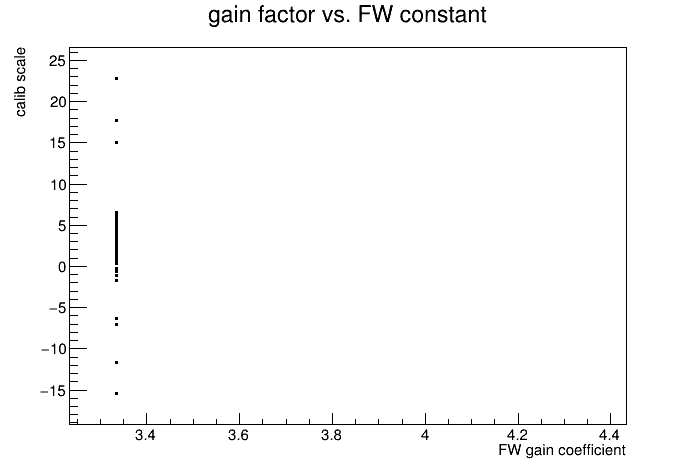

In [21]:
calibGain = r.TGraph();
for k in range(0, len(laserConstants)):
    if(k%100 == 0):
        print("point", k)
    #//std::cout<< "laser "<<laserConstants.at(k) << std::endl;
    #//std::cout<< "calib "<<scales.at(k) << std::endl;
    calibGain.SetPoint(k, 1.0 / laserConstants[k], 1.0 / scales[k]);

c3 = r.TCanvas("c3","c3",700,500);
calibGain.SetTitle("gain factor vs. FW constant; FW gain coefficient; calib scale");
calibGain.SetMarkerStyle(7);
calibGain.Draw("apz");
c3.Draw();


In [22]:
for xtal, value in enumerate(scales):
    if(value == 1.0):
        print("Problem xtal:", xtal, "( calo", int(np.ceil(xtal/54)), "xtal", xtal%54,")")

Problem xtal: 0 ( calo 0 xtal 0 )
Problem xtal: 11 ( calo 1 xtal 11 )
Problem xtal: 38 ( calo 1 xtal 38 )
Problem xtal: 40 ( calo 1 xtal 40 )
Problem xtal: 48 ( calo 1 xtal 48 )
Problem xtal: 49 ( calo 1 xtal 49 )
Problem xtal: 221 ( calo 5 xtal 5 )
Problem xtal: 222 ( calo 5 xtal 6 )
Problem xtal: 224 ( calo 5 xtal 8 )
Problem xtal: 227 ( calo 5 xtal 11 )
Problem xtal: 230 ( calo 5 xtal 14 )
Problem xtal: 236 ( calo 5 xtal 20 )
Problem xtal: 237 ( calo 5 xtal 21 )
Problem xtal: 244 ( calo 5 xtal 28 )
Problem xtal: 246 ( calo 5 xtal 30 )
Problem xtal: 247 ( calo 5 xtal 31 )
Problem xtal: 255 ( calo 5 xtal 39 )
Problem xtal: 256 ( calo 5 xtal 40 )
Problem xtal: 258 ( calo 5 xtal 42 )
Problem xtal: 263 ( calo 5 xtal 47 )
Problem xtal: 266 ( calo 5 xtal 50 )
Problem xtal: 279 ( calo 6 xtal 9 )
Problem xtal: 433 ( calo 9 xtal 1 )
Problem xtal: 434 ( calo 9 xtal 2 )
Problem xtal: 442 ( calo 9 xtal 10 )
Problem xtal: 443 ( calo 9 xtal 11 )
Problem xtal: 444 ( calo 9 xtal 12 )
Problem xtal: 4

In [23]:
print("BEGIN_PROLOG")
print("absolute_calibration_constants : {")
#for(int calo = 1; calo <= 24; calo++){
for calo in range(1,25):
    #std::cout<<Form("\tcalo%i : {",calo)<<std::endl;
    print("\t"+"calo"+str(calo))
    #for(int xtal = 0; xtal < 54; xtal++){
    for xtal in range(54):
        #std::cout<<Form("\t\txtal%i : %0.3f",xtal,scales.at(54*(calo-1)+xtal))<<std::endl;
        print("\t"+"\t"+"xtal"+str(xtal)+" : "+str(scales[54*(calo-1)+xtal]))
    print("\t"+"}")
    #std::cout<<"\t}"<<std::endl;
print("}")
print("END_PROLOG")

BEGIN_PROLOG
absolute_calibration_constants : {
	calo1
		xtal0 : 1.0
		xtal1 : 0.7078018432655097
		xtal2 : 0.7078035872312654
		xtal3 : 0.7078018432655094
		xtal4 : 0.5663321576266173
		xtal5 : 0.471998646986299
		xtal6 : 0.3668017940990427
		xtal7 : 0.4565285848887588
		xtal8 : 0.47842179362339987
		xtal9 : 0.4665054392006862
		xtal10 : 0.35403668969306096
		xtal11 : 1.0
		xtal12 : 0.3540340548110364
		xtal13 : 0.28325175944314357
		xtal14 : 0.3371003678452629
		xtal15 : 0.3303831811005026
		xtal16 : 0.7989543336844493
		xtal17 : 0.39043870390317464
		xtal18 : 0.48022162164152815
		xtal19 : 0.5089194118286008
		xtal20 : 0.35403608740340736
		xtal21 : 0.47199191045401506
		xtal22 : 0.40459155178547135
		xtal23 : 0.3474376144592191
		xtal24 : 0.42201295268051253
		xtal25 : 2.558638346658059
		xtal26 : 0.3939492796716544
		xtal27 : 0.5255417258219194
		xtal28 : 0.3540375195115342
		xtal29 : 0.28324970682579903
		xtal30 : 0.35403687516707916
		xtal31 : 0.4719810596960945
		xtal32 : 2.855